## GCM Filters on Irregular Grids with Irregular Filter Scale

This notebook will use data from the idealized one-basin NeverWorld2 configuration performed in MOM6.

We will filter data which is on an irregular grid (hozirontal grid spacing dx varies with latitude, dy is constant).

The filtering scale will be related to the size of the local deformation radius, which is also spatially varying.

In [2]:
import gcm_filters
import numpy as np
#import cupy as cp
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from dask.diagnostics import ProgressBar
#import cartopy
import cartopy.crs as ccrs
import cmocean
print('done')

done


### Execute the following cell to read in NW2 data for 1/4 (run 20), 1/8 (run 26), or 1/16 (run 28) degree 

In [3]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=20 #1/4 degree 
#run=26 #1/8 degree
#run=28 #1/16 degree

fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/


/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


### Execute the following cell to read in NW2 data for 1/32 degree (run 33)

In [4]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=33; factor = 1440/86400 #1/32 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00002000.nc' % (run), decode_times=False)
init=xr.open_dataset('run33/MOM_IC.nc', decode_times=False)
av=xr.open_mfdataset(['run33/averages_00001502.nc','run33/averages_00001602.nc', 'run33/averages_00001702.nc', 'run33/averages_00001802.nc', 'run33/averages_00001902.nc'],decode_times=False,combine='by_coords')
# print(av)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [5]:
Nx = np.size(av.xh)
xhp = av.xh
Ny = np.size(av.yh)
yhp = av.yh
print('Nx = %i, Ny = %i' %(Nx,Ny))

Nx = 1920, Ny = 4480


### The following are the grid types that we have so far implemented in GCM-filters:

In [6]:
list(gcm_filters.GridType)


[<GridType.CARTESIAN: 1>,
 <GridType.CARTESIAN_WITH_LAND: 2>,
 <GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>]

### To filter with fixed filter length scale, we will use the grid type: IRREGULAR_CARTESIAN_WITH_LAND, and its associated Laplacian. The Laplacian needs the following grid variables:

In [7]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND)


['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area', 'kappa_w', 'kappa_s']

In our example, we will filter tracer fields, i.e., fields that are defined at T-points (e.g., h, KE).

(IRREGULAR_CARTESIAN_WITH_LAND could also be used to filter U-fields or V-fields, but we would have to create the filter with different arguments for wet_mask, dxw, dyw, dxs, dys, area.)

wet_mask and area we have directly available from our model output:

In [8]:
wet_mask = fs.wet
area = fs.area_t

For the remaining grid variables, recall the following conventions:

dxw = x-spacing centered at western cell edge

dyw = y-spacing centered at western cell edge

dxs = x-spacing centered at southern cell edge

dys = y-spacing centered at southern cell edge

We get these grid variables from our model output as follows:

In [10]:
dxw = xr.DataArray(data=fs.dxCu.isel(xq=slice(0,Nx)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dyw = xr.DataArray(data=fs.dyCu.isel(xq=slice(0,Nx)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dxs = xr.DataArray(data=fs.dxCv.isel(yq=slice(0,Ny)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dys = xr.DataArray(data=fs.dyCv.isel(yq=slice(0,Ny)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))

Ld = xr.DataArray(av.Rd1.mean(dim='time'))
Ld = Ld.fillna(np.nanmax(Ld))

#ind = np.isnan(Ld)
#Ld[ind] = np.nanmax(Ld)
print(Ld)

<xarray.DataArray 'Rd1' (yh: 4480, xh: 1920)>
array([[445470.72, 445470.72, 445470.72, ..., 445470.72, 445470.72,
        445470.72],
       [445470.72, 445470.72, 445470.72, ..., 445470.72, 445470.72,
        445470.72],
       [445470.72, 445470.72, 445470.72, ..., 445470.72, 445470.72,
        445470.72],
       ...,
       [445470.72, 445470.72, 445470.72, ..., 445470.72, 445470.72,
        445470.72],
       [445470.72, 445470.72, 445470.72, ..., 445470.72, 445470.72,
        445470.72],
       [445470.72, 445470.72, 445470.72, ..., 445470.72, 445470.72,
        445470.72]], dtype=float32)
Coordinates:
  * xh       (xh) float64 0.01562 0.04688 0.07812 0.1094 ... 59.92 59.95 59.98
  * yh       (yh) float64 -69.98 -69.95 -69.92 -69.89 ... 69.92 69.95 69.98


/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [11]:
# fig,axs = plt.subplots(2,3,figsize=(25,15))
# wet_mask.plot(ax=axs[0,0])
# axs[0,0].set_title('wet_mask')
# dxw.plot(ax=axs[0,1])
# axs[0,1].set_title('dxw = x-spacing centered at western cell edge')
# dyw.plot(ax=axs[0,2])
# axs[0,2].set_title('dyw = y-spacing centered at western cell edge')
# dxs.plot(ax=axs[1,0])
# axs[1,0].set_title('dxs = x-spacing centered at southern cell edge')
# dys.plot(ax=axs[1,1])
# axs[1,1].set_title('dys = y-spacing centered at southern cell edge')
# area.plot(ax=axs[1,2])
# axs[1,2].set_title('area')

While the y-spacing is constant over our domain, the x-spacing varies with latitude:

In [12]:
# dxw.isel(xh=30).plot()


The filter needs to know what the minimum grid spacing is in our model.

In [13]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_max = max(dxw.max(),dyw.max(),dxs.max(),dys.max())

dx_min = dx_min.values
dx_max = dx_max.values
dx_min, dx_max

(array(1189.77157473), array(3478.65936538))

In our example, we choose the (fixed) filter scale to be 100km. (Note that we need: filter_scale >= dx_min.)

In [14]:
#filter_scale = 100000
Lf = np.max(Ld.data)
filter_scale = Lf
kappa_w = Ld**2 / Lf**2
kappa_s = Ld**2 / Lf**2

In [15]:
np.max(kappa_w)

<xarray.DataArray 'Rd1' ()>
array(1.)

In [16]:
filter = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    transition_width=2*np.pi,
    n_steps=50,
    grid_type=gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 
               'area': area, 'kappa_w': kappa_w, 'kappa_s': kappa_s}
)
filter

Filter(filter_scale=445470.72, dx_min=array(1189.77157473), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=6.283185307179586, ndim=2, n_steps=50, grid_type=<GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>)

In [17]:

KEfull = av.KE[-1,:,:,:]
print(KEfull.shape)
KEfull_filtered = filter.apply(KEfull, dims=['yh', 'xh'])


(15, 4480, 1920)


In [18]:
KEfull_filtered.shape


(15, 4480, 1920)

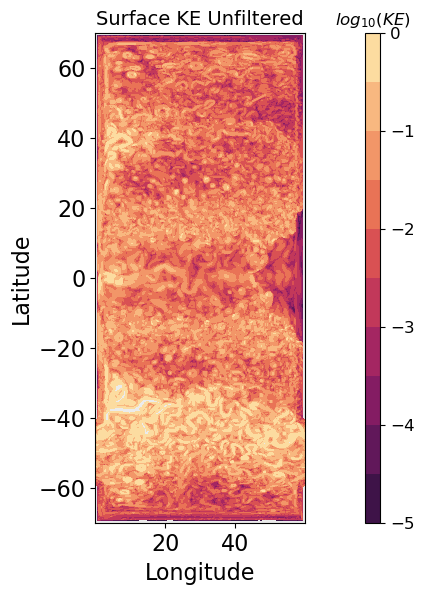

In [19]:
#Plotting KE 
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Surface KE Unfiltered',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)
#ax2.set_title('$log_{10}(m^2/s^2)$',fontsize=10)

#KE_surface[(KE_surface)<1e-5]==1e-5
#levels=np.linspace(0.,.05,51) #not logarithmic colormap
levels=np.linspace(-5,0,11)
plotted =ax1.contourf(xhp,yhp,np.log10(KEfull[0,:,:]),levels=levels,cmap=cmocean.cm.matter_r)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
ax2.set_title('$log_{10}(KE)$')
#
plt.show()

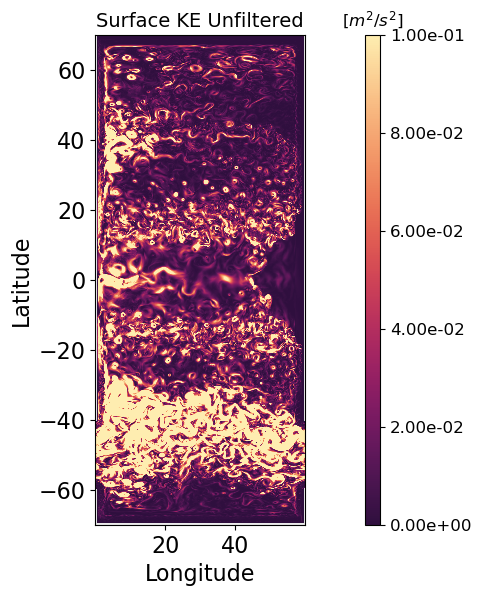

In [20]:
#Plotting KE 
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Surface KE Unfiltered',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)
#ax2.set_title('$log_{10}(m^2/s^2)$',fontsize=10)

#KE_surface[(KE_surface)<1e-5]==1e-5
#levels=np.linspace(0.,.05,51) #not logarithmic colormap
#levels=np.linspace(0,1e-1,11)
plotted =ax1.pcolor(xhp,yhp,(KEfull[0,:,:]),cmap=cmocean.cm.matter_r,vmin=0,vmax=1e-1)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical',format='%.2e');
cbar.ax.tick_params(labelsize=12);
ax2.set_title('$[m^2/s^2]$')
#
plt.show()

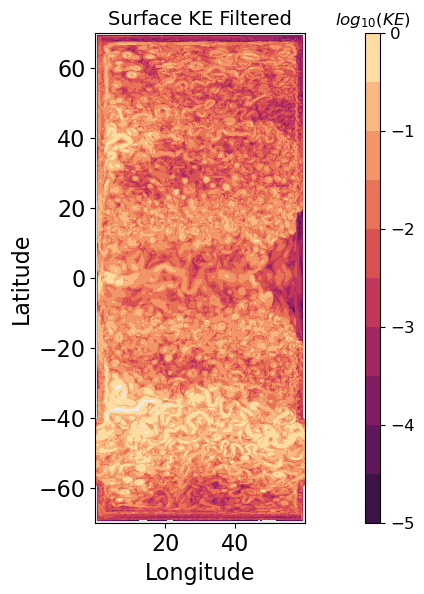

In [27]:
#Plotting KE 
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Surface KE Filtered',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)
#ax2.set_title('$log_{10}(m^2/s^2)$',fontsize=10)

#KE_surface[(KE_surface)<1e-5]==1e-5
#levels=np.linspace(0.,.05,51) #not logarithmic colormap
levels=np.linspace(-5,0,11)
var = KEfull_filtered[0,:,:]
plotted =ax1.contourf(xhp,yhp,np.log10(var),levels=levels,cmap=cmocean.cm.matter_r)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
ax2.set_title('$log_{10}(KE)$')
#
plt.show()

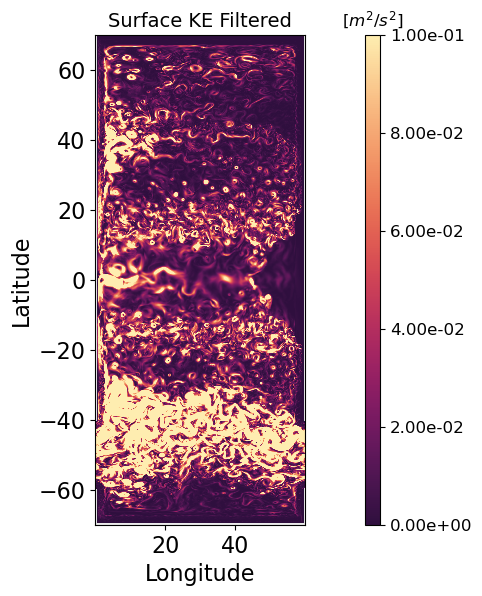

In [29]:
#Plotting KE 
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Surface KE Filtered',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)
#ax2.set_title('$log_{10}(m^2/s^2)$',fontsize=10)

#KE_surface[(KE_surface)<1e-5]==1e-5
#levels=np.linspace(0.,.05,51) #not logarithmic colormap
#levels=np.linspace(-5,0,11)
var = KEfull_filtered[0,:,:]
plotted =ax1.pcolor(xhp,yhp,var,cmap=cmocean.cm.matter_r,vmin=0,vmax=1e-1)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical',format='%.2e');
cbar.ax.tick_params(labelsize=12);
ax2.set_title('$[m^2/s^2]$')
#
plt.show()

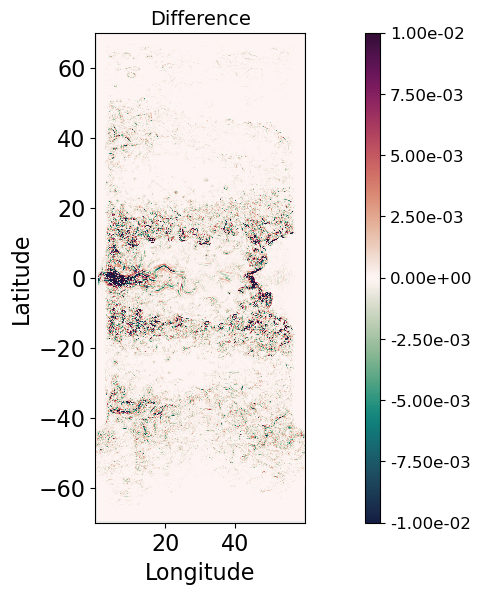

In [30]:
#Plotting KE 
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Difference',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)
#ax2.set_title('$log_{10}(m^2/s^2)$',fontsize=10)

#KE_surface[(KE_surface)<1e-5]==1e-5
#levels=np.linspace(0.,.05,51) #not logarithmic colormap
#levels=np.linspace(-5,0,11)
plotted =ax1.pcolor(xhp,yhp,(KEfull_filtered[0,:,:])-KEfull[0,:,:],cmap=cmocean.cm.curl,vmin=-1e-2,vmax=1e-2)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical',format='%.2e');
cbar.ax.tick_params(labelsize=12);
#
plt.show()

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


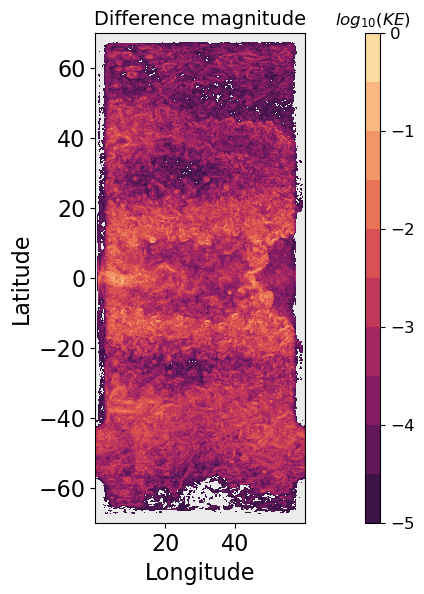

In [31]:
#Plotting KE 
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Difference magnitude',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)
#ax2.set_title('$log_{10}(m^2/s^2)$',fontsize=10)

#KE_surface[(KE_surface)<1e-5]==1e-5
#levels=np.linspace(0.,.05,51) #not logarithmic colormap
levels=np.linspace(-5,0,11)
plotted =ax1.contourf(xhp,yhp,np.log10(abs(KEfull_filtered[0,:,:]-KEfull[0,:,:])),levels=levels,cmap=cmocean.cm.matter_r)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
ax2.set_title('$log_{10}(KE)$')
#
plt.show()

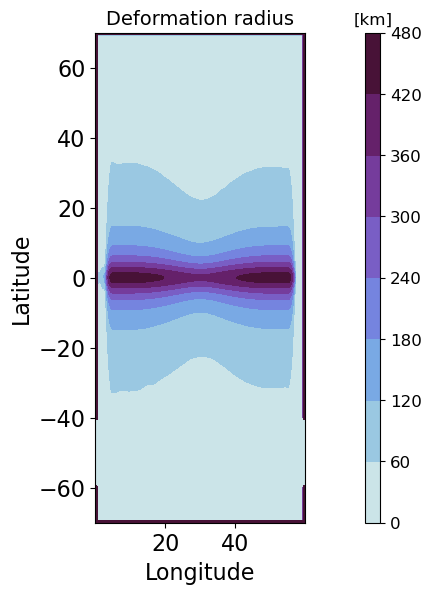

In [32]:
#Plotting Rd
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Deformation radius',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)
#ax2.set_title('$log_{10}(m^2/s^2)$',fontsize=10)

#KE_surface[(KE_surface)<1e-5]==1e-5
#levels=np.linspace(0.,.05,51) #not logarithmic colormap

plotted =ax1.contourf(xhp,yhp,Ld/1000,cmap=cmocean.cm.dense)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
ax2.set_title('[km]')
#
plt.show()

In [196]:
Ld.shape

(560, 240)